# PMT Gain Simulator

A PMT works based on the photoelectric effect and secondary emission:

*  **Photoemission**: When a photon strikes the photocathode of the PMT, it can eject an electron (a photoelectron) if its energy is above the work function of the photocathode material.

*  **Acceleration**: These photoelectrons are then accelerated towards a series of electrodes called dynodes by an electric field.


*  **Secondary Emission**: Each accelerated electron strikes the first dynode with enough energy to knock out several secondary electrons.

*  **Multiplication Chain**: These secondary electrons are then accelerated to the next dynode, where each electron again knocks out more secondary electrons. This process repeats at each dynode, creating a cascade of electrons.

*  **Anode Collection**: After passing through all the dynodes, the large number of electrons reach the anode, where they are collected as an electric current pulse.

The total amplification (gain) of the PMT is the product of the multiplication factors at each dynode. The simulator models secondary emission at each dynode by using a Poisson distribution in the dynode_multiply_Poisson function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

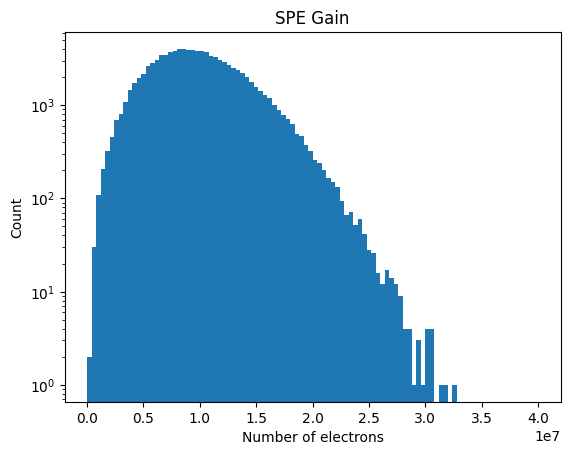

In [16]:
# dynode multification factor
mu_stage = 4.9

# number of multiplication dynodes in a PMT
N_stage=10

# simulate the multiplication process many many times
N_trial=100000


def simulate_poisson_stage_gain(mu_stage, N_stage):
  """
  Simulate a single PE multication process in a PMT.
  Each multiplication follows a Poisson distribution.

  Args:
    N_stage: (int) number of multiplication dynodes in a PMT
    mu_stage: (float) dynode multification factor.
  """
  ne = 1
  for i in range(N_stage):
    pre_ne = np.random.poisson(mu_stage*ne)+1
    ne = pre_ne
  return ne


# simulate the multiplication many times
ne_arr = np.zeros(N_trial)
for j in range(N_trial):
  ne = simulate_poisson_stage_gain(mu_stage, N_stage)
  ne_arr[j] = ne


# Plot the distribution
plt.hist(ne_arr, bins=100, range=(0, 4e7))
plt.yscale('log')
plt.xlabel('Number of electrons')
plt.ylabel('Count')
plt.title('SPE Gain')
plt.show()

## Define gamma pdf function for curve fit

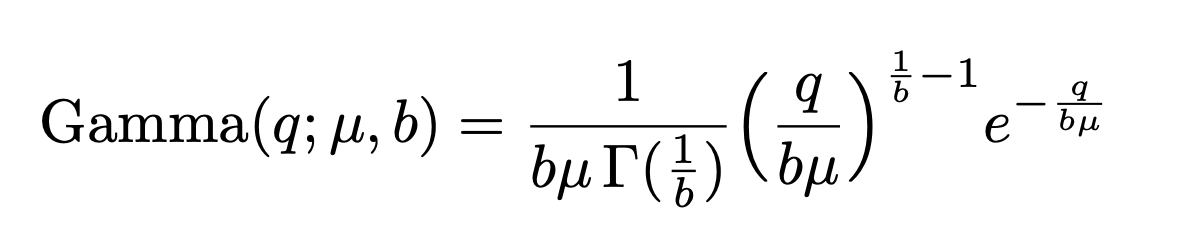


In [3]:
from scipy.special import gamma as gamma_func

def gamma_pdf(x, mu, b, norm=1):
  """
  The Gamma distribution as in Eq. 4 of arXiv:1705.10183.

  Args:
    x: The value at which to calculate the PDF.
    mu: distribution mean
    b: The shape parameter
    norm: arb normalization constant

  Returns:
    The PDF value at x.
  """
  part1 = 1/(b*mu*gamma_func(1/b))
  part2 = np.power((x/(b*mu)),1/b-1)
  part3 = np.exp(-x/(b*mu))
  return part1*part2*part3*norm

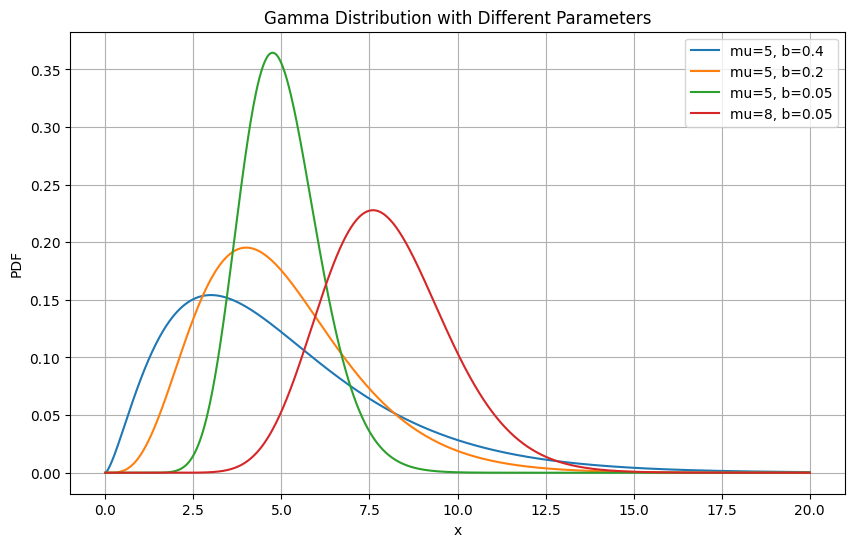

In [4]:
# Define a range of x values
x_values = np.linspace(0, 20, 800)

# Plot gamma_pdf with different parameters
plt.figure(figsize=(10, 6))


plt.plot(x_values, gamma_pdf(x_values, mu=5, b=0.4), label='mu=5, b=0.4')
plt.plot(x_values, gamma_pdf(x_values, mu=5, b=0.2), label='mu=5, b=0.2')
plt.plot(x_values, gamma_pdf(x_values, mu=5, b=0.05), label='mu=5, b=0.05')
plt.plot(x_values, gamma_pdf(x_values, mu=8, b=0.05), label='mu=8, b=0.05')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Gamma Distribution with Different Parameters')
# plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

## Perform chi-squared fit to the simulated histogram


In [6]:
# Make histogram from simulator data
counts, bin_edges = np.histogram(ne_arr, bins=100, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# define fit range (chi2 does not work well when statistics is low)
qx = np.quantile(ne_arr, [0.05, 0.95])
mask = (bin_centers>qx[0]) & (bin_centers<qx[-1])
counts_msk = counts[mask]
bin_centers_msk = bin_centers[mask]


from scipy.optimize import curve_fit

# mean & variance are useful guess for initial parameters
p0=[1e7, 0.1, np.trapezoid(counts_msk, bin_centers_msk)]

# Use the filtered data for curve_fit
params, covariance = curve_fit(gamma_pdf, bin_centers_msk, counts_msk, sigma=np.sqrt(counts_msk) ,p0=p0)

mu, b, norm = params

print(f"Fitted mu: {mu}")
print(f"Fitted b: {b}")
print(f"Fitted norm: {norm}")

Fitted mu: 10367853.194196232
Fitted b: 0.1733376637286366
Fitted norm: 31703344468.520844


## Plot histogram and fitted pdf

Plot the original histogram and overlay the Gamma PDF with the fitted parameters.


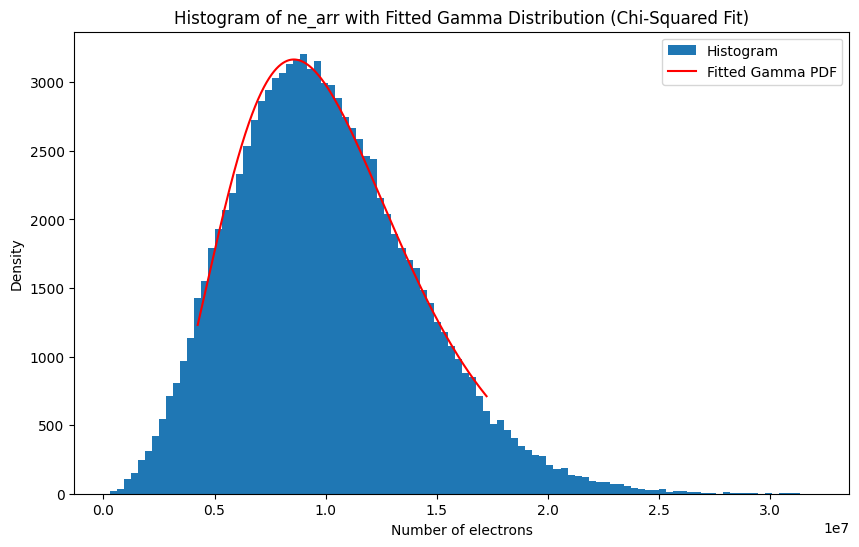

In [7]:
x_fit = np.linspace(bin_centers_msk[0], bin_centers_msk[-1], 1000)
pdf_fit = gamma_pdf(x_fit, mu, b, norm)

plt.figure(figsize=(10, 6))
plt.hist(ne_arr, bins=100, label='Histogram')
plt.plot(x_fit, pdf_fit, label='Fitted Gamma PDF', color='red')
plt.xlabel('Number of electrons')
plt.ylabel('Density')
plt.title('Histogram of ne_arr with Fitted Gamma Distribution (Chi-Squared Fit)')
plt.legend()
plt.show()

In [8]:
# evaulate the goodness of the fit using chi2

def calc_chi2(func, popt, xdata, ydata, sigma):
  ymodel = func(xdata, popt[0], popt[1], popt[2])
  res = ydata-ymodel
  chi2 = np.square(res/sigma)
  return np.sum(chi2)

def calc_reduced_chi2(func, popt, xdata, ydata, sigma):
  npar = len(popt) # num of free parameters
  dof = len(xdata) - npar
  return calc_chi2(func, popt, xdata, ydata, sigma)/dof

rchi2 = calc_reduced_chi2(gamma_pdf, params, bin_centers_msk, counts_msk, np.sqrt(counts_msk))

print("the goodness of fit: ", rchi2)

the goodness of fit:  3.326604619677121


## Note: the Goodness of the fit is close to 1, but not quite right. The simulator above assume a Possion process at each dynode. This is technically incorrect.


-----------------------------


# The Correct PMT simulator

## Why the PMT Gain Distribution is Over-Dispersed (Variance > Mean)?

**The Core Assumption Violation: Lack of Independence**

*   **Poisson Requirement:** For a Poisson distribution, events must be independent. The probability of one event occurring does not affect the probability of another event occurring.
*   **Dynode Reality:** The secondary electrons emitted from a single primary electron impact are **NOT** independent. They share a common origin and, crucially, compete for a limited pool of energy deposited by the primary electron.

**The Energy Budget Constraint (The Root Cause):**

When a primary electron hits the dynode material, it deposits a finite amount of kinetic energy (determined by the accelerating voltage). This energy is used to:

1.  Excite electrons from the valence band into the conduction band.
2.  Give these excited electrons enough kinetic energy to reach the surface.
3.  Overcome the work function to escape the surface (become secondary electrons).

This total available energy is fixed for a given primary electron impact energy. Let's call this total available energy $E_{total}$.

**The Multi-Emission Process is Competitive. So modeling the multiplication at each dynode using Poission process is wrong!!!!!**



## The Prescott (1966) Model: Deriving the Polya Distribution

As discussed in the paper by Prescott (1966), the observation that the SPE charge distribution in PMTs follows a Polya distribution can be derived from first principles by modeling the underlying physical processes at each dynode:

*   **Primary electron energy loss:** The energy lost by the primary electron as it penetrates the dynode material is modeled as exponentially distributed.
*   **Internal secondary generation:** The number of secondary electrons generated *within* the dynode material by the primary electron is modeled as following a Poisson distribution.

By combining these two processes and considering the probability of generated electrons escaping the surface, Prescott showed that the resulting emitted electron distribution follows a Polya distribution.

Experimental measurements of pulse-height distributions from single photoelectrons have shown good agreement with the predictions of the Polya distribution, providing strong experimental validation for this model (e.g., Fig. 2 in Prescott).

For a standard Negative Binomial distribution parameterized by the number of successes ($r$) and the probability of success ($p$), the mean is given by:

$\mu = \frac{r(1-p)}{p}$

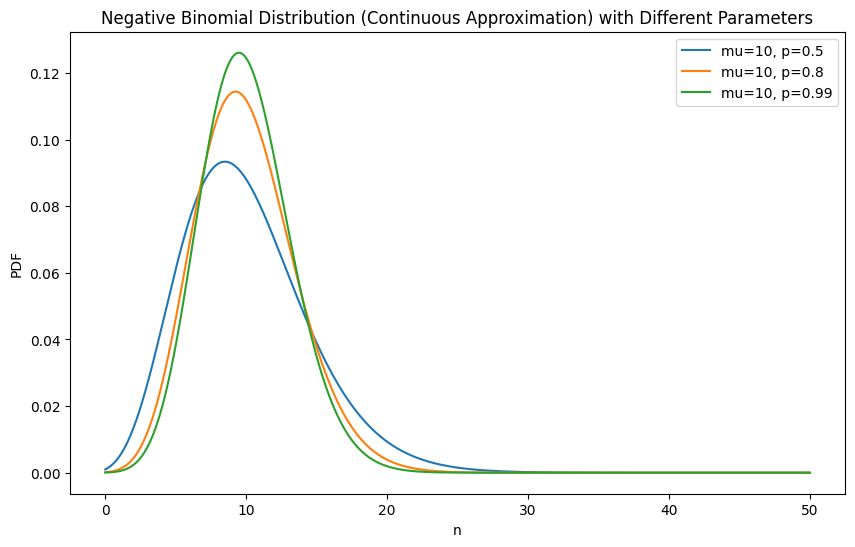

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as gamma_func
from scipy.special import loggamma

def neg_binomial_pdf(n, mu, p, norm=1):
  """
  Negative Binomial distribution PDF (continuous approximation).

  Args:
    n: The value at which to calculate the PDF.
    mu: the mean of the distribution. mu = r*(1-p)/p
    p: The probability of success in each trial.
    norm: Optional normalization constant.

  Returns:
    The PDF value at n.
  """

  # r: The number of successes (shape parameter, can be non-integer).
  # Mean = r*(1-p)/p  => r = Mean * p / (1-p)
  r = mu*p/(1-p)

  # Define conditions for invalid inputs
  invalid_conditions = (n < 0) | (r <= 0) | (p <= 0) | (p > 1)

  # Calculate the PDF only for valid inputs, return 0 for invalid inputs
  log_coeff = np.where(invalid_conditions, -np.inf, loggamma(n + r) - loggamma(n + 1) - loggamma(r))
  log_prob = np.where(invalid_conditions, -np.inf, r * np.log(p) + n * np.log(1 - p))

  # Avoid -inf + inf issues by setting the result to 0 where conditions are invalid
  return np.where(invalid_conditions, 0, norm * np.exp(log_coeff + log_prob))


# Plot neg_binomial_pdf with different parameters
x_values = np.linspace(0, 50, 500) # Adjust range based on expected values

plt.figure(figsize=(10, 6))

plt.plot(x_values, neg_binomial_pdf(x_values, mu=10, p=0.5), label='mu=10, p=0.5')
plt.plot(x_values, neg_binomial_pdf(x_values, mu=10, p=0.8), label='mu=10, p=0.8')
plt.plot(x_values, neg_binomial_pdf(x_values, mu=10, p=0.99), label='mu=10, p=0.99')

plt.xlabel('n')
plt.ylabel('PDF')
plt.title('Negative Binomial Distribution (Continuous Approximation) with Different Parameters')
plt.legend()
# plt.yscale('log')
plt.show()

Note: a sum of independent and identically distributed Negative Binomial variables (which is what happens when multiple electrons hit a dynode) follows another Negative Binomial distribution, which for large means can be approximated by a Gamma distribution.

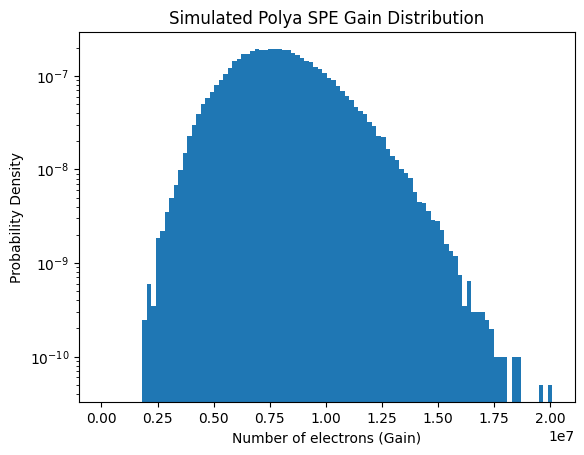

In [10]:

from scipy.special import gamma as gamma_func
from scipy.special import loggamma


# Average gain per incident electron at a stage (mean of the stage-wise NB distribution)
mu_stage = 4.9

# Probability parameter of the stage-wise NB distribution (0 < p_stage < 1)
p_stage = 0.8 # Example value (adjust to control over-dispersion)

# Number of multiplication stages
N_stage = 10

# Number of single photoelectron events to simulate
N_trial = 100000

def simulate_polya_stage_gain(mu_stage, p_stage, N_stage):
  """
  Simulates PMT single photoelectron gain where each stage's gain *per incident electron*
  follows a Negative Binomial distribution parameterized by mean (mu_stage) and
  probability of success (p_stage).

  Args:
    mu_stage: Average gain per incident electron at each stage.
    p_stage: Probability of success parameter for the stage-wise NB distribution.
    N_stage: Number of dynode stages.

  Returns:
    The total number of electrons collected at the anode for one single photoelectron event.
  """
  ne = 1  # Start with a single photoelectron

  # Calculate the equivalent r and theta parameters for the stage-wise NB distribution
  # with mean mu_stage and probability p_stage.
  # Mean = r*(1-p)/p  => r = Mean * p / (1-p)
  r_stage = mu_stage * p_stage / (1 - p_stage)
  # Variance = r*(1-p)/p^2
  # Over-dispersion = (1-p)/p
  # Relationship with Gamma: NB(r, p) is equivalent to Gamma(r, (1-p)/p)
  theta_stage = (1 - p_stage) / p_stage # Scale parameter for the equivalent Gamma distribution

  for i in range(N_stage):
    # Generate a sample from Gamma(ne * r_stage, theta_stage)
    ne_next_stage = np.random.gamma(shape=ne * r_stage, scale=theta_stage)

    ne = int(round(ne_next_stage)) # Round to nearest integer number of electrons

    # Handle cases where ne becomes 0
    if ne <= 0 and i < N_stage - 1:
      return 0 # If no electrons survive and not at the last stage, the final gain is 0
    elif ne <= 0 and i == N_stage - 1:
        ne = 0 # Ensure final gain is 0 if it rounded to 0 at the last stage

  return ne


# Run the simulation
ne_data = np.zeros(N_trial)
for j in range(N_trial):
  ne_data[j] = simulate_polya_stage_gain(mu_stage, p_stage, N_stage)

# Plot the distribution
plt.hist(ne_data, bins=100, range=(0, np.max(ne_data)), density=True)
plt.yscale('log')
plt.xlabel('Number of electrons (Gain)')
plt.ylabel('Probability Density')
plt.title('Simulated Polya SPE Gain Distribution')
plt.show()

In [11]:
# Make histogram from simulator data
counts, bin_edges = np.histogram(ne_data, bins=100, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# define fit range (chi2 does not work well when statistics is low)
qx = np.quantile(ne_data, [0.05, 0.95])
mask = (bin_centers>qx[0]) & (bin_centers<qx[-1])
counts_msk = counts[mask]
bin_centers_msk = bin_centers[mask]


from scipy.optimize import curve_fit

# Calculate mean and variance of the masked data for a better initial guess
mean_masked_data = np.average(bin_centers_msk, weights=counts_msk)
variance_masked_data = np.average((bin_centers_msk - mean_masked_data)**2, weights=counts_msk)

# Initial guess for Gamma parameters (mu, b, norm) based on masked data moments
# Mean = mu
# Variance = b * mu^2  => b = Variance / mu^2
mu_guess = mean_masked_data
# Ensure mu_guess is not zero before calculating b_guess
if mu_guess > 0:
  b_guess = variance_masked_data / (mu_guess**2)
else:
  b_guess = 1.0 # Default guess if mean is zero or negative

# Initial guess for norm is related to the total counts in the masked region and bin width
bin_width = bin_edges[1] - bin_edges[0]
norm_guess = np.sum(counts_msk) * bin_width


p0=[mu_guess, b_guess, norm_guess]

# Use the filtered data for curve_fit
params, covariance = curve_fit(gamma_pdf, bin_centers_msk, counts_msk, sigma=np.sqrt(counts_msk) ,p0=p0)

mu, b, norm = params

print(f"Fitted mu: {mu}")
print(f"Fitted b: {b}")
print(f"Fitted norm: {norm}")

Fitted mu: 8024183.326387159
Fitted b: 0.06571472432967351
Fitted norm: 18112935835.189278


## Plot histogram and fitted pdf

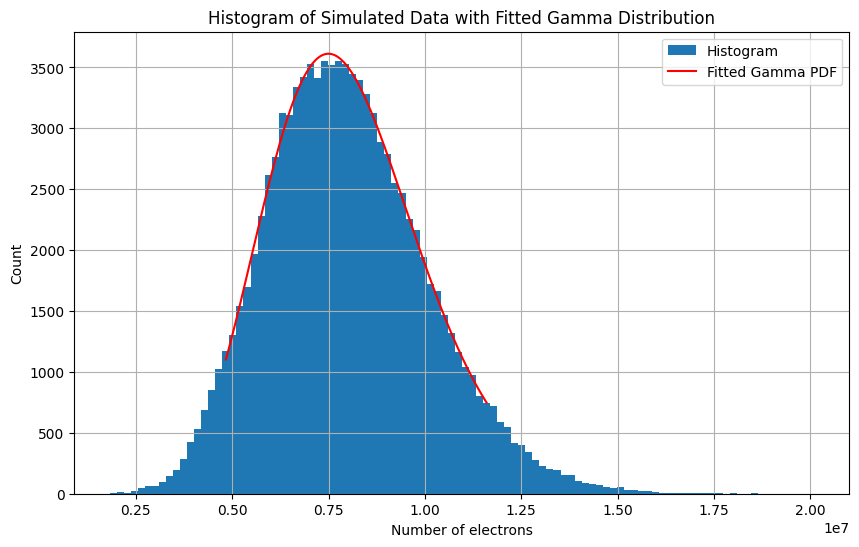

In [12]:
# Generate x values for the fitted curve, covering the range of the masked data
x_fit = np.linspace(bin_centers_msk[0], bin_centers_msk[-1], 1000)

# Calculate the fitted Gamma PDF values using the obtained parameters
pdf_fit = gamma_pdf(x_fit, mu, b, norm)

# Plot the original histogram and the fitted Gamma PDF
plt.figure(figsize=(10, 6))
plt.hist(ne_data, bins=100, label='Histogram') # Plot the original histogram (can adjust bins/range if needed)
plt.plot(x_fit, pdf_fit, label='Fitted Gamma PDF', color='red')

plt.xlabel('Number of electrons')
plt.ylabel('Count' if counts.max() > 1 else 'Density') # Adjust y-label based on histogram type
plt.title('Histogram of Simulated Data with Fitted Gamma Distribution')
plt.legend()
# plt.yscale('log') # Uncomment to use log scale on the y-axis
plt.grid(True)
plt.show()

## Evaluate goodness of fit

In [13]:
# Calculate the fitted PDF values at the masked bin centers
pdf_fit_at_centers_msk = gamma_pdf(bin_centers_msk, mu, b, norm)

# Calculate the chi-squared statistic
chi2 = np.sum(((counts_msk - pdf_fit_at_centers_msk) / np.sqrt(counts_msk))**2)

# Calculate the number of degrees of freedom
# degrees of freedom (dof) = number of data points - number of fitted parameters
n_data_points = len(counts_msk)
n_fitted_parameters = len(params) # mu, b, norm

dof = n_data_points - n_fitted_parameters

# Calculate the reduced chi-squared statistic
reduced_chi2 = chi2 / dof

print(f"Chi-squared: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"Reduced chi-squared: {reduced_chi2}")

Chi-squared: 53.43755386995599
Degrees of freedom: 35
Reduced chi-squared: 1.5267872534273141


#The Goodness of fit is much better 🙂